In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime as dt


In [2]:
#df = pd.read_csv('GLD.csv', parse_dates = True, index_col = 0)

In [3]:
start = '2004-5-31'

In [4]:
df = yf.download('GC=F', start)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-23,2371.199951,2371.199951,2335.000000,2335.000000,2335.000000,365
2024-05-24,2342.600098,2345.399902,2332.500000,2332.500000,2332.500000,25
2024-05-28,2336.899902,2359.699951,2336.899902,2355.199951,2355.199951,26
2024-05-29,2340.300049,2340.300049,2340.300049,2340.300049,2340.300049,26
2024-05-30,2361.000000,2361.699951,2343.300049,2355.300049,2355.300049,64940


In [6]:
df.to_csv('gold.csv')

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-01,393.899994,399.0,393.299988,394.600006,394.600006,1864
2004-06-02,394.500000,397.5,390.000000,390.700012,390.700012,937
2004-06-03,390.700012,393.0,387.399994,388.100006,388.100006,601
2004-06-04,388.399994,391.5,385.500000,390.899994,390.899994,234
2004-06-07,392.600006,394.0,392.000000,393.799988,393.799988,130


In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-23,2371.199951,2371.199951,2335.000000,2335.000000,2335.000000,365
2024-05-24,2342.600098,2345.399902,2332.500000,2332.500000,2332.500000,25
2024-05-28,2336.899902,2359.699951,2336.899902,2355.199951,2355.199951,26
2024-05-29,2340.300049,2340.300049,2340.300049,2340.300049,2340.300049,26
2024-05-30,2361.000000,2361.699951,2343.300049,2355.300049,2355.300049,64940


In [9]:
df_settle = df['Adj Close'].resample('M').last()

In [10]:
df_settle

Date
2004-06-30     392.600006
2004-07-31     391.000000
2004-08-31     410.399994
2004-09-30     418.700012
2004-10-31     428.500000
                 ...     
2024-01-31    2048.399902
2024-02-29    2045.699951
2024-03-31    2217.399902
2024-04-30    2291.399902
2024-05-31    2355.300049
Freq: M, Name: Adj Close, Length: 240, dtype: float64

In [11]:
df_rolling = df_settle.rolling(12)
df_mean = df_rolling.mean()
df_std = df_rolling.std()

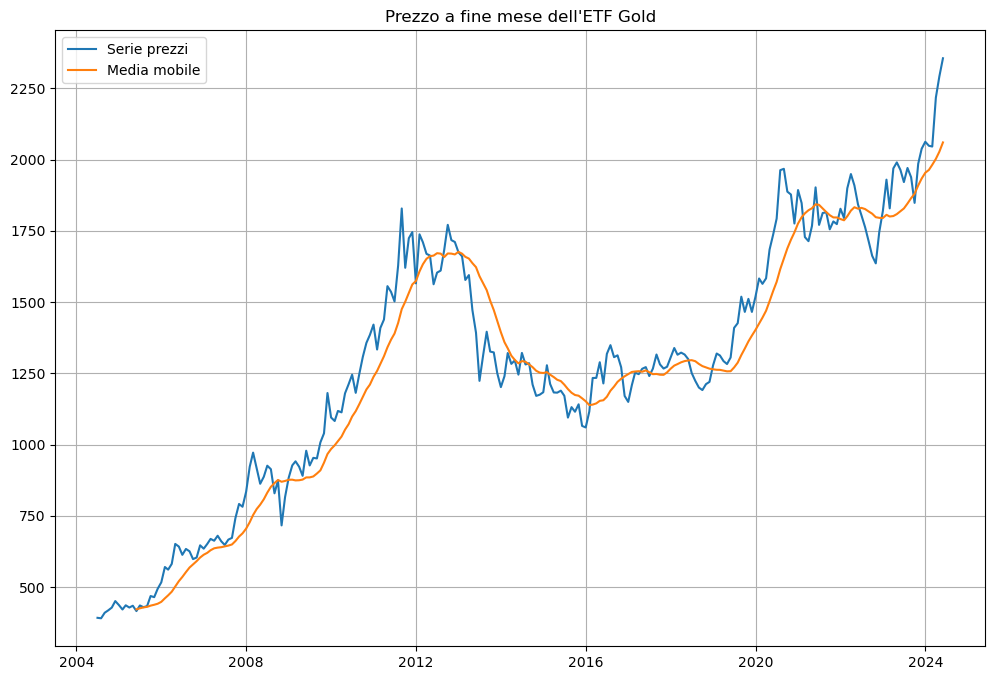

In [12]:
plt.figure(figsize=(12,8))
plt.plot(df_settle, label = 'Serie prezzi')
plt.plot(df_mean, label = 'Media mobile')
plt.legend()
plt.title("Prezzo a fine mese dell'ETF Gold")
plt.grid()
plt.show()

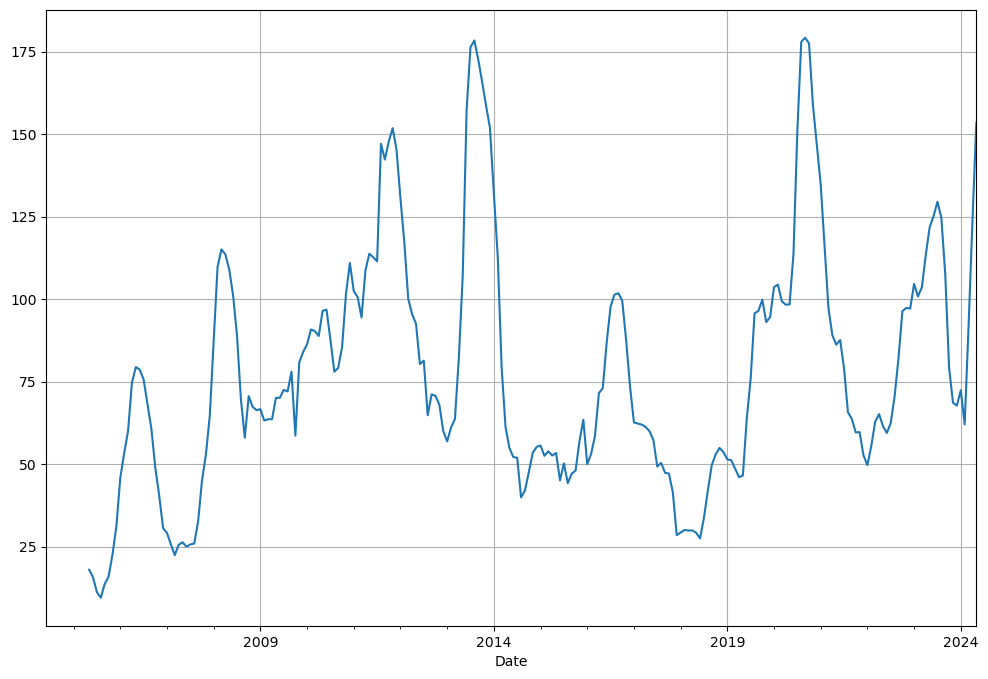

In [13]:
df_std.plot(figsize=(12,8))
plt.grid();

#### Verifica stazionarietà

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
result = adfuller(df_settle)

In [16]:
print('ADF statistic: ', result[0])
print('p-value: ', result[1])

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -0.517158013426929
p-value:  0.8886245110981994
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


#### Detrending

In [17]:
df_log = np.log(df_settle)

In [18]:
df_log_ma = df_log.rolling(2).mean()

In [19]:
df_detrend = df_log - df_log_ma
df_detrend.dropna(inplace= True)

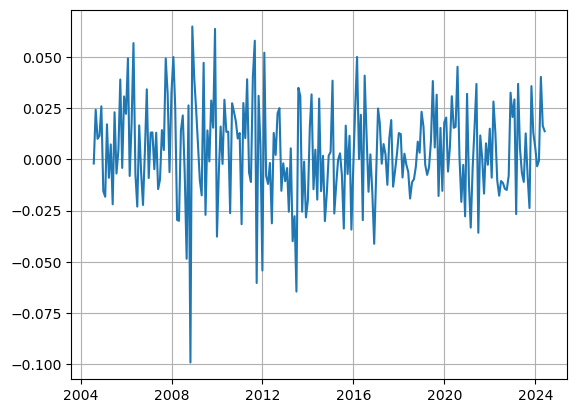

In [20]:
plt.plot(df_detrend)
plt.grid(True)

In [21]:
df_detrend_rolling = df_detrend.rolling(12)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

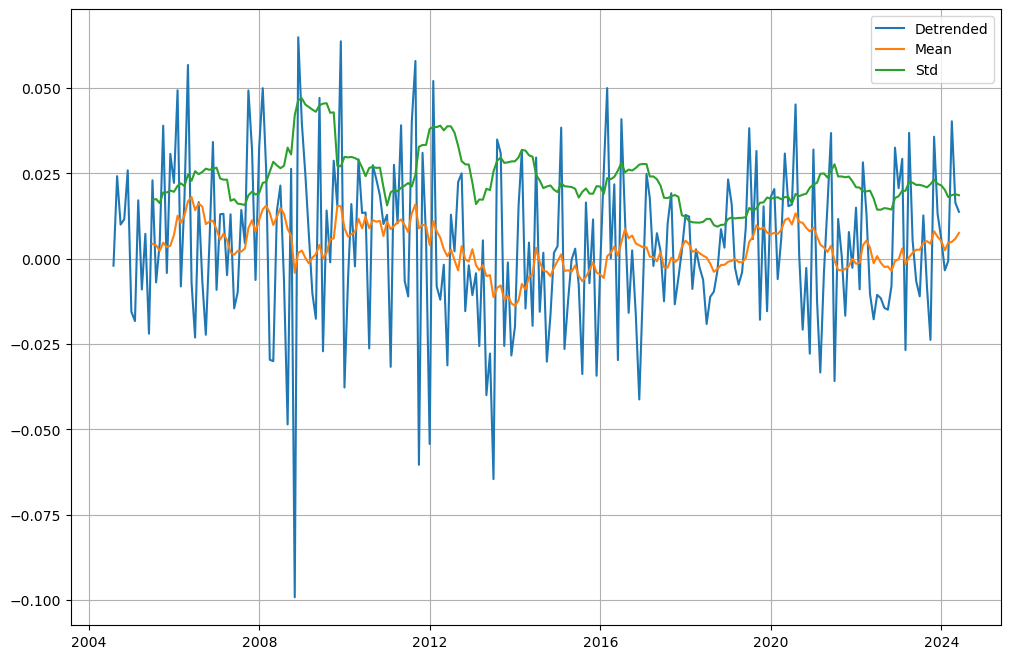

In [22]:
plt.figure(figsize=(12,8))
plt.plot(df_detrend, label = 'Detrended')
plt.plot(df_detrend_ma, label = 'Mean')
plt.plot(df_detrend_std, label = 'Std')
plt.legend(loc='upper right')
plt.grid()
plt.show();


In [23]:
result = adfuller(df_detrend)
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1],5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))


ADF statistic:  -17.111715031995278
p-value:  0.0
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


In [24]:
df_log_diff = df_log.diff(1).dropna()

df_log_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_log_diff_rolling.mean()
df_diff_std = df_log_diff_rolling.std()


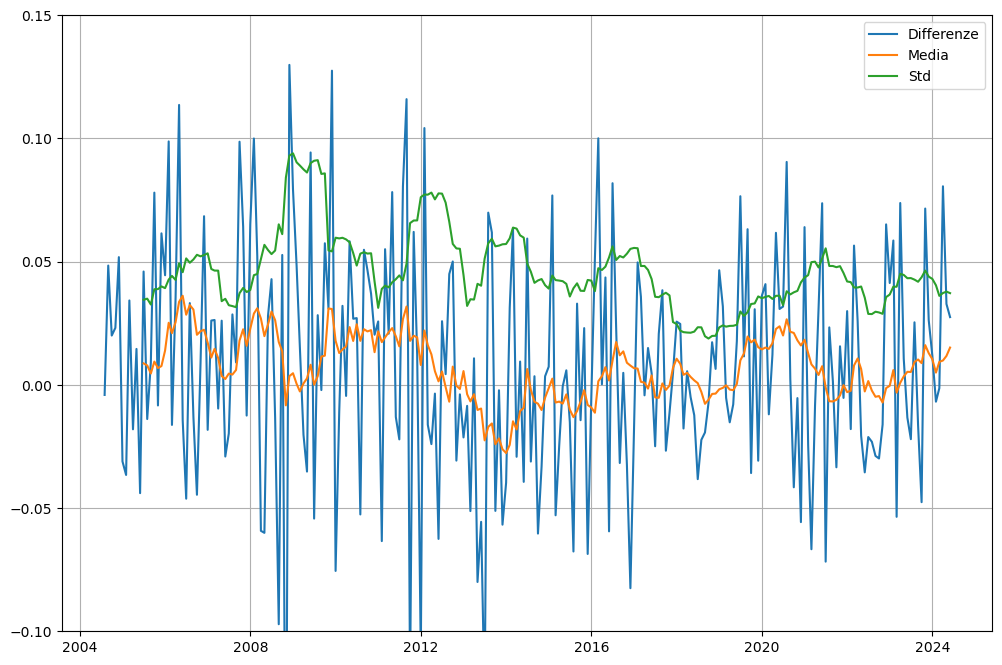

In [25]:
plt.figure(figsize = (12,8))
plt.plot(df_log_diff, label = 'Differenze')
plt.plot(df_diff_ma, label = 'Media')
plt.plot(df_diff_std, label = 'Std')
plt.legend(loc = 'upper right')
plt.ylim((-0.10, 0.15))
plt.grid();
plt.show()

In [26]:
result = adfuller(df_log_diff)
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1], 5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))



ADF statistic:  -17.111715031995267
p-value:  0.0
Critical value (1%): -3.458
Critical value (5%): -2.874
Critical value (10%): -2.573


#### Scomposizione 

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
decompose_result = seasonal_decompose(df_log.dropna()) #freq=12)

In [29]:
df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

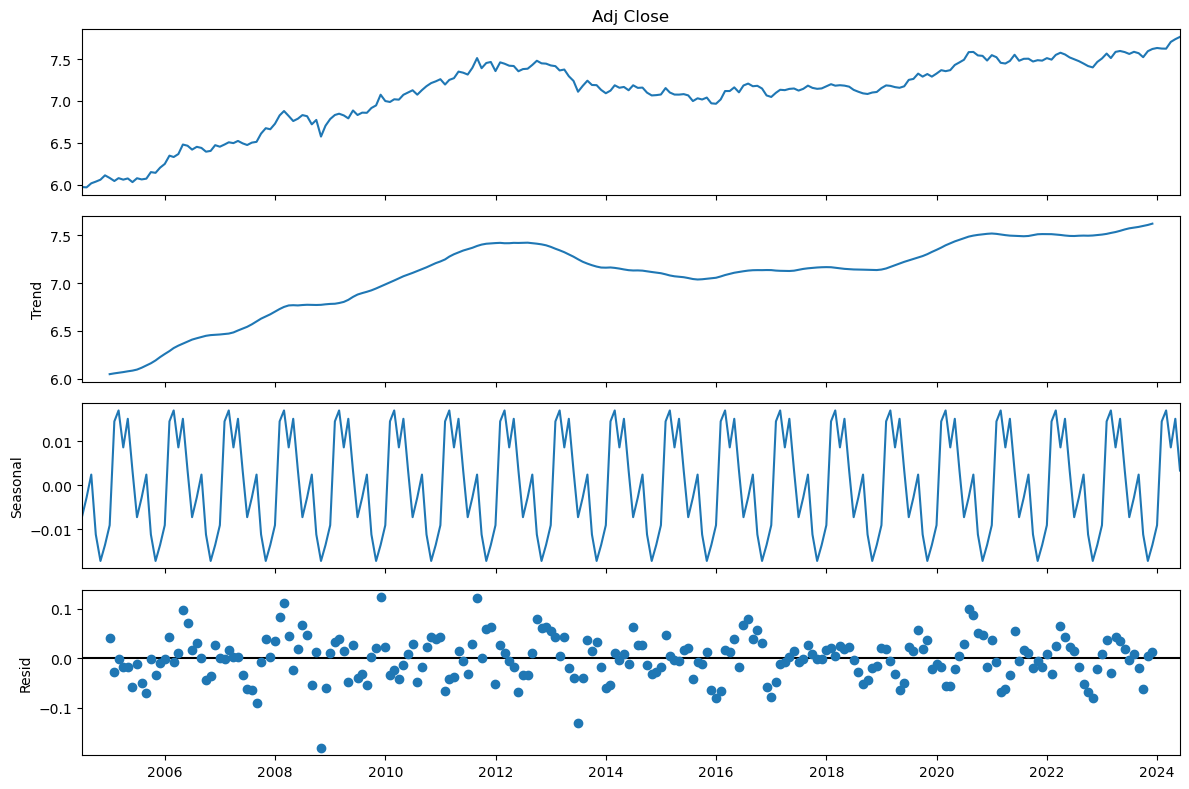

In [30]:
plt.rcParams['figure.figsize'] = (12,8)
fig = decompose_result.plot()

In [31]:
df_log_diff = df_residual.diff().dropna()

In [32]:
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

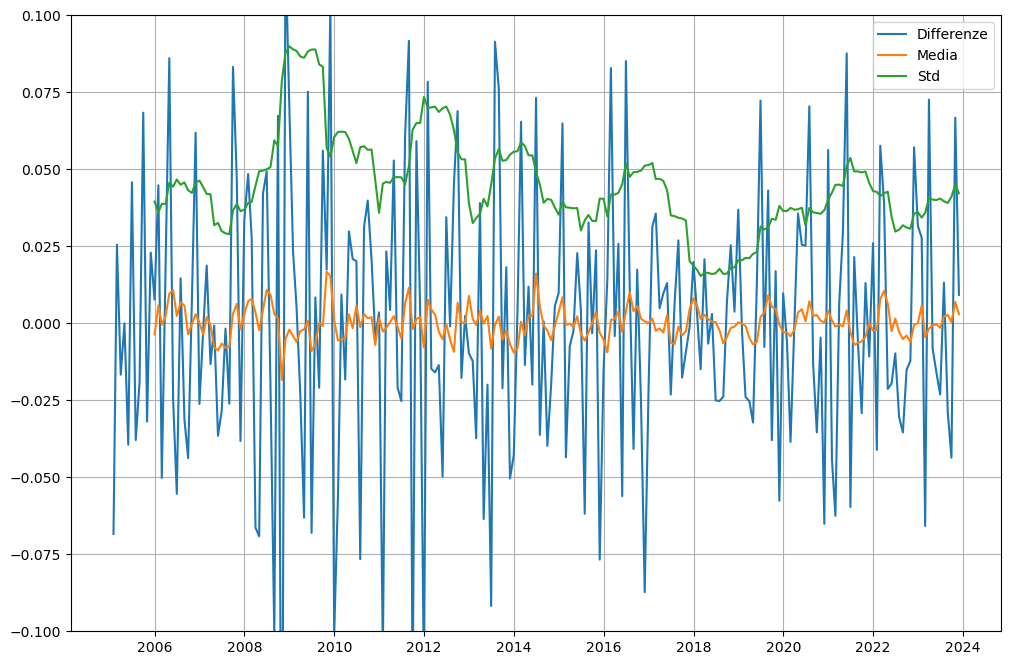

In [33]:
plt.figure(figsize=(12,8))
plt.plot(df_log_diff, label = 'Differenze')
plt.plot(df_diff_ma, label = 'Media')
plt.plot(df_diff_std, label = 'Std')
plt.grid(True)
plt.ylim((-0.10, 0.10))
plt.legend();

In [34]:
result = adfuller(df_residual.dropna())
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1], 5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))


ADF statistic:  -6.800995968776131
p-value:  0.0
Critical value (1%): -3.461
Critical value (5%): -2.875
Critical value (10%): -2.574


#### ARIMA

In [35]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

In [36]:
def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(df_settle, order = order,
                               seasonal_order= seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp = False
                               )
                model_result = model.fit(maxiter=200, disp=False)
                
                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            
            except Exception as ex:
                continue
                
    return lowest_aic, pdq, pdqs

In [37]:
df_settle

Date
2004-06-30     392.600006
2004-07-31     391.000000
2004-08-31     410.399994
2004-09-30     418.700012
2004-10-31     428.500000
                 ...     
2024-01-31    2048.399902
2024-02-29    2045.699951
2024-03-31    2217.399902
2024-04-30    2291.399902
2024-05-31    2355.300049
Freq: M, Name: Adj Close, Length: 240, dtype: float64

In [38]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)

In [39]:
print('ARIMA {}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA (0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 2409.435


In [40]:
model = SARIMAX(df_settle, order = order,
                               seasonal_order= seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp = False
                               )
model_results = model.fit(maxiter=200, disp=False)
print(model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1201.717
Date:                            Thu, 30 May 2024   AIC                           2409.435
Time:                                    11:28:43   BIC                           2419.519
Sample:                                06-30-2004   HQIC                          2413.510
                                     - 05-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1112      0.054     -2.070      0.038      -0.216      -0.006
ma.S.L12      -0.8822      0.066   

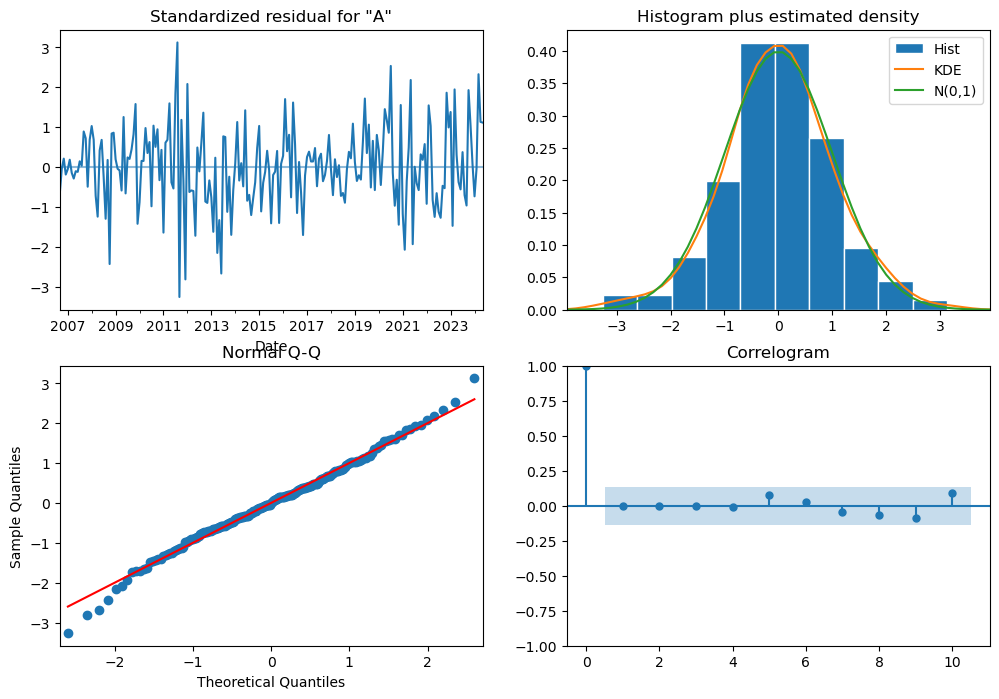

In [41]:
model_results.plot_diagnostics(figsize=(12,8));

In [43]:
model_results.resid.describe()

count    240.000000
mean       1.678370
std       71.115441
min     -242.137922
25%      -38.414093
50%        2.761509
75%       37.979415
max      392.600006
dtype: float64

#### Previsioni con SARIMAX

In [44]:
n = len(df_settle.index)
prediction = model_results.get_prediction(start=n-12*5, end = n+5)
prediction_ci = prediction.conf_int()

In [45]:
print(prediction_ci.head())

            lower Adj Close  upper Adj Close
2019-06-30      1164.100934      1425.779992
2019-07-31      1271.766286      1533.442522
2019-08-31      1317.336764      1578.816630
2019-09-30      1369.009462      1630.486911
2019-10-31      1336.763334      1598.240753


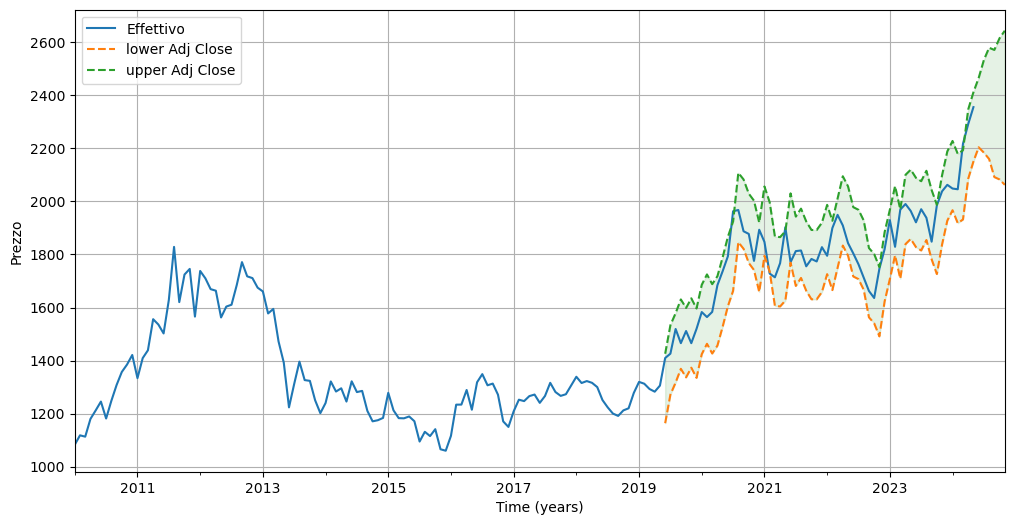

In [46]:
plt.figure(figsize=(12,6))
ax = df_settle['2010':].plot(label = 'Effettivo')
prediction_ci.plot(ax=ax, style = ['--', '--'],
                  label = 'predicted/forecasted')
ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:,0]
upper_ci = prediction_ci.iloc[:,1]

ax.fill_between(ci_index, lower_ci, upper_ci, color = 'g', alpha = 0.1)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Prezzo')
plt.grid()
plt.legend()
plt.show()